## Calculate balanced machine learning measures (UPDRS+ and Imaging Data)

From request [Calculate balanced machine learning measures](https://trello.com/c/fGlOzVVt)

Using the `average='weighted'` in scoring

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.2
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_random_seed = 55

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[10  3]
 [ 5 25]]

recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372


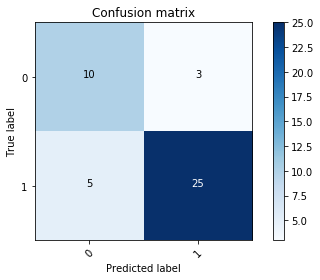

In [3]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0113227367401	0.000861408787683
score_time	0.0069016456604	0.00142888687071
test_recall	0.858947368421	0.0729398492365
train_recall	0.881234177215	0.0263255383405
test_precision	0.923698830409	0.0264310503776
train_precision	0.986255086072	0.0122710423822
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.900952380952	0.0358125631942
train_specificity	0.982330827068	0.0158331734056
test_npv	0.826587301587	0.078020353825
train_npv	0.856753770423	0.0255876012875
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


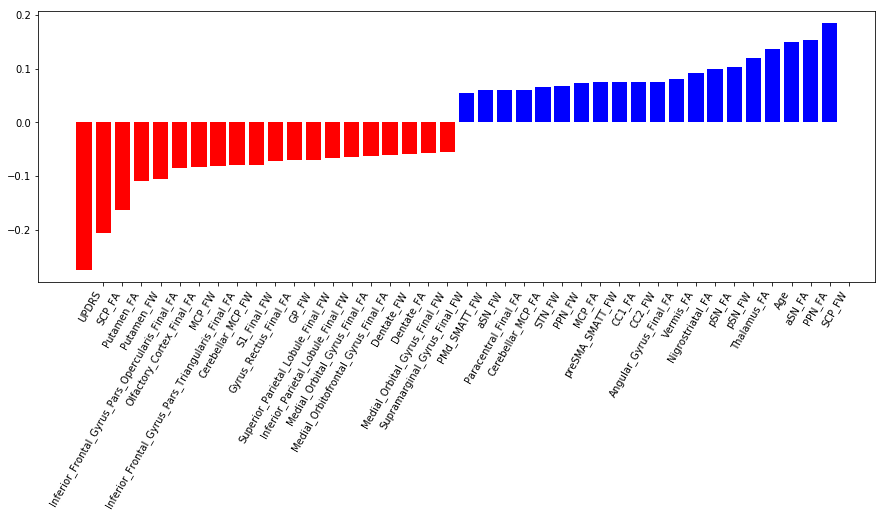

Age	0.136385091108
Sex	0.0408123164569
UPDRS	-0.274976658545
aSN_FA	0.149135031144
Caudate_FA	0.0193797749595
CC2_FA	0.0248632210564
GP_FA	-0.0264047804513
LobuleVI_FA	0.0382352213832
LobuleV_FA	-0.0458763629965
MCP_FA	0.0743042979131
pSN_FA	0.0987483199736
Putamen_FA	-0.162424527963
SCP_FA	-0.205717807841
STN_FA	0.051329541284
Thalamus_FA	0.120659934842
Vermis_FA	0.0807117121331
RN_FA	-0.0123614406316
PPN_FA	0.154129234307
Dentate_FA	-0.0591345261233
CC1_FA	0.0754134224956
aSN_FW	0.0600026486026
Caudate_FW	0.0116718481648
CC2_FW	0.0757994586719
GP_FW	-0.0697233298565
LobuleVI_FW	0.0180492676601
LobuleV_FW	-0.0221203395051
MCP_FW	-0.0831810525834
pSN_FW	0.103091874529
Putamen_FW	-0.109811747783
SCP_FW	0.18549290771
STN_FW	0.0660217555143
Thalamus_FW	0.0426365099806
Vermis_FW	-0.0272819392868
RN_FW	0.0451764130632
PPN_FW	0.0688197872224
Dentate_FW	-0.0601393450813
CC1_FW	0.0171111268717
Angular_Gyrus_Final_FA	0.0759778822611
Anterior_Orbital_Gyrus_Final_FA	-0.0391670044483
Calcarine_Sul

In [5]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43



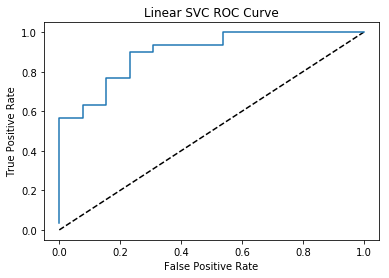

0.0 0.0333333333333
0.0 0.566666666667
0.0769230769231 0.566666666667
0.0769230769231 0.633333333333
0.153846153846 0.633333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.307692307692 0.9
0.307692307692 0.933333333333
0.538461538462 0.933333333333
0.538461538462 1.0
1.0 1.0


In [6]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 6. MSA (positive) vs PSP (negative)

In [7]:
# Get the data
data4 = group_classes(_data, {2:1, 3:0})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


In [8]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0106036663055	0.00102236705668
score_time	0.00640201568604	0.000490099090724
test_recall	0.900952380952	0.0358125631942
train_recall	0.982330827068	0.0158331734056
test_precision	0.826587301587	0.078020353825
train_precision	0.856753770423	0.0255876012875
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.858947368421	0.0729398492365
train_specificity	0.881234177215	0.0263255383405
test_npv	0.923698830409	0.0264310503776
train_npv	0.986255086072	0.0122710423822
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


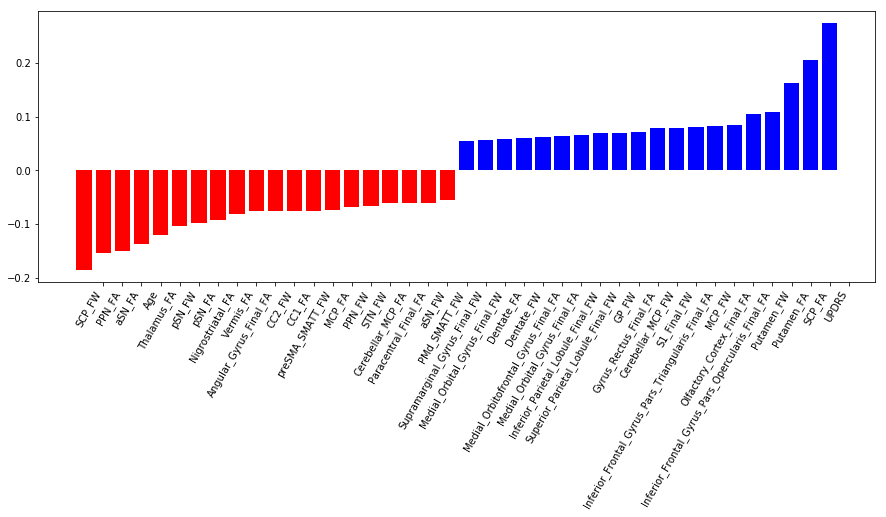

Age	-0.136409040829
Sex	-0.0408684239088
UPDRS	0.275024665333
aSN_FA	-0.149188410171
Caudate_FA	-0.0192993078021
CC2_FA	-0.0246956730561
GP_FA	0.0265136804937
LobuleVI_FA	-0.0381976313152
LobuleV_FA	0.0459978555446
MCP_FA	-0.0742755079312
pSN_FA	-0.0987578471785
Putamen_FA	0.162387844256
SCP_FA	0.205724218313
STN_FA	-0.051307521595
Thalamus_FA	-0.120684730605
Vermis_FA	-0.0809031018927
RN_FA	0.0124111194893
PPN_FA	-0.154205547056
Dentate_FA	0.0591106318817
CC1_FA	-0.0755776173622
aSN_FW	-0.0599536265546
Caudate_FW	-0.0115940011855
CC2_FW	-0.0758295551283
GP_FW	0.0697418831905
LobuleVI_FW	-0.0180495574067
LobuleV_FW	0.0220088302957
MCP_FW	0.0832207237751
pSN_FW	-0.103023628875
Putamen_FW	0.109834222454
SCP_FW	-0.185488485673
STN_FW	-0.0660084277757
Thalamus_FW	-0.0427216064969
Vermis_FW	0.0273440190972
RN_FW	-0.045285295148
PPN_FW	-0.0687590185557
Dentate_FW	0.0601093475301
CC1_FW	-0.0171509994711
Angular_Gyrus_Final_FA	-0.0760822622479
Anterior_Orbital_Gyrus_Final_FA	0.0392220985714
Ca

In [9]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43



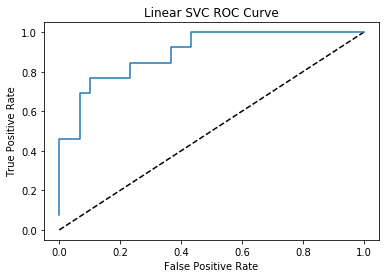

0.0 0.0769230769231
0.0 0.461538461538
0.0666666666667 0.461538461538
0.0666666666667 0.692307692308
0.1 0.692307692308
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.366666666667 0.846153846154
0.366666666667 0.923076923077
0.433333333333 0.923076923077
0.433333333333 1.0
1.0 1.0


In [10]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)